In [1]:
import argparse
from ml_collections import config_dict

import jax
import jax.numpy as jnp

from molpipx import EnergyPIP, PIPlayer as PIP
from molpipx import training, training_w_gradients, get_forces
from molpipx import split_train_and_test_data, split_train_and_test_data_w_forces
from molpipx import flax_params
from molpipx import mse_loss
from molpipx import get_functions, detect_molecule

# from load_data_methane import read_geometry_energy


def get_number_of_atoms(molecule_dict):
    na = 0
    for i, k in enumerate(molecule_dict):
        na += molecule_dict[k]
    return na


def train_and_evaluate(config: config_dict.ConfigDict,
                       workdir: str, energy_normalization=False):

    print(config)

    n_tr = config.ntr
    n_val = config.nval
    molecule_type = config.molecule
    poly_degree = config.poly_degree
    # get monomials and polynomials functions
    mol_dict, mol_sym = detect_molecule(molecule_type)
    na = get_number_of_atoms(mol_dict)
    f_mono, f_poly = get_functions(molecule_type, poly_degree)

    # load all molecule data
    X_all, _, y_all, atoms = read_geometry_energy(
        energy_normalization=energy_normalization)

    # split training and validation data
    i0 = 0
    rng = jax.random.PRNGKey(i0)
    _, key = jax.random.split(rng)
    (X_tr, y_tr), (X_val, y_val) = split_train_and_test_data(
        X_all, y_all, n_tr, key, n_val)

    # load PIP-Flax model
    model_pip = PIP(f_mono, f_poly)
    model_energy = EnergyPIP(f_mono, f_poly)
    params = model_energy.init(key, X_tr[:1])

    # training
    w = training(model_pip, X_tr, y_tr) 
    params = flax_params(w, params)  # transform to Pytree

    # prediction
    y_pred_tr = model_energy.apply(params, X_tr)
    y_pred_val = model_energy.apply(params, X_val)
    print(y_pred_tr.shape, y_pred_val.shape)

    loss_tr = mse_loss(y_pred_tr, y_tr)
    loss_val = mse_loss(y_pred_val, y_val)

    print(n_tr, loss_tr, loss_val)
    results = {'X_tr': X_tr, 'y_tr': y_tr, 'y_pred_tr': y_pred_tr,
               'X_val': X_val, 'y_val': y_val, 'y_pred_val': y_pred_val,
              "loss_tr": loss_tr, "loss_val": loss_val}

    results_file = f'{workdir}/results_N_{n_tr}_deg_{poly_degree}.npy'

    jnp.save(results_file, results, allow_pickle=True)

    return results_file, results


def train_and_evaluate_w_gradients(config: config_dict.ConfigDict,
                                   workdir: str,
                                  energy_normalization: bool = False):

    print(config)
    
    n_tr = config.ntr
    n_val = config.nval
    molecule_type = config.molecule
    poly_degree = config.poly_degree
    # get monomials and polynomials functions
    mol_dict, mol_sym = detect_molecule(molecule_type)
    na = get_number_of_atoms(mol_dict)
    f_mono, f_poly = get_functions(molecule_type, poly_degree)

    # load all molecule data
    X_all, F_all, y_all, atoms = read_geometry_energy(
        energy_normalization=energy_normalization)

    # split training and validation data
    i0 = np.random.randint(100)
    print("****")
    print("i0", i0)
    rng = jax.random.PRNGKey(i0)
    _, key = jax.random.split(rng)
    (X_tr, F_tr, y_tr), (X_val, F_val, y_val) = split_train_and_test_data_w_forces(
        X_all, F_all, y_all, n_tr, key, n_val)

    # load PIP-Flax model
    model_pip = PIP(f_mono, f_poly)
    model_energy = EnergyPIP(f_mono, f_poly)
    params = model_energy.init(key, X_tr[:1])

    # training
    w = training_w_gradients(model_pip, X_tr, F_tr, y_tr)
    params = flax_params(w, params)

    # prediction Energy
    y_pred_tr = model_energy.apply(params, X_tr)
    y_pred_val = model_energy.apply(params, X_val)
    print(y_pred_tr.shape, y_pred_val.shape)

    # prediction Forces
    F_pred_tr = get_forces(model_energy.apply, X_tr, params)
    F_pred_val = get_forces(model_energy.apply, X_val, params)

    loss_energy_tr = mse_loss(y_pred_tr, y_tr)
    loss_energy_val = mse_loss(y_pred_val, y_val)

    loss_tr = mse_loss(y_pred_tr, y_tr)
    loss_val = mse_loss(y_pred_val, y_val)
    
    # loss_force_tr = mse_loss(F_pred_tr, F_tr)
    # loss_force_val = mse_loss(F_pred_val, F_val)
   

    loss_force_tr = jnp.linalg.norm(F_pred_tr - F_tr)
    loss_force_val = jnp.linalg.norm(F_pred_val - F_val)
    
    print(n_tr, loss_energy_tr, loss_energy_val, loss_force_tr, loss_force_val)

    results = {'X_tr': X_tr, 'F_tr': F_tr, 'y_tr': y_tr, 
               'y_pred_tr': y_pred_tr, 'F_pred_tr': F_pred_tr,
               'X_val': X_val, 'y_val': y_val, 
               'y_pred_val': y_pred_val, 'y_pred_val': y_pred_val, 
               'F_tr': F_tr,
               "F_val": F_val,
               'F_pred_val': F_pred_val,
               'F_pred_tr': F_pred_tr,
               "loss_force_tr": loss_force_tr,
               "loss_force_val": loss_force_val,
                             "loss_tr": loss_tr, "loss_val": loss_val}

    results_file = f'{workdir}/results_N_{n_tr}_deg_{poly_degree}_wgrad.npy'
    jnp.save(results_file, results, allow_pickle=True)
    return results_file, results

2025-02-26 23:32:21.547249: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: CUDA error: : CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2025-02-26 23:32:21.695044: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.8.61. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import os
import re
import numpy as np
import jax.numpy as jnp

ang_to_bohr = 0.529177210929
bhor_to_ang = ang_to_bohr * 1.0e-1


def is_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False


def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


def read_geometry_energy(filename: str = "/pchem-data/meuwly/boittier/home/pyscfgpu/tests/data/combined.xyz", 
                         num_atoms: int = 5,
                         energy_normalization: bool = False):

    print(os.getcwd())
    with open(filename, 'r') as file:
        data = file.read()

    # Split the data into blocks using a blank line as a separator
    blocks = re.split(r'\s\s5\n', data.strip())
    print("n blocks", len(blocks))
    # Initialize lists to store geometries and energies
    geometries = []
    energies = []
    atoms = []

    # Process each block

    for block in blocks:
        lines = block.split('\n')

        # Extract energy from the first line of each block
        if is_float(lines[0]) and not is_int(lines[0]):
            energy = float(lines[0])
        elif is_int(lines[0]):
            energy = float(lines[1])

        # Extract atom coordinates
        coordinates = []
        atoms_i = []
        for line in lines[1:]:
            parts = line.split()
            if len(parts) == 4 + 3:
                atom, x, y, z, dx, dy, dz = parts
                coordinates.append([float(x), float(y), float(
                    z), float(dx), float(dy), float(dz)])
                atoms_i.append((atom))

        # Append data to lists
        geometries.append(list(coordinates))
        energies.append(energy)
        atoms.append(list(atoms_i))
    
    energies = np.array(energies)
    geometries_and_forces = np.array(geometries) 
    geometries = geometries_and_forces[:, :, 0:3] # 1 / ang_to_bohr
    forces = geometries_and_forces[:, :, 3:] 
    if energy_normalization:
        Eref = np.zeros([20], dtype=float)
        Eref[1] = -0.498232909223
        Eref[6] = -37.731440432799
        Eref[8] = -74.878159582108
        Eref[17] = -459.549260062932
        energies -= np.array([-0.498232909223 * 2 + 2*-459.549260062932 + -37.731440432799]*len(energies))

    
    return jnp.array(geometries), jnp.array(forces), jnp.array(energies[:, np.newaxis]), np.array(atoms)


def main():

    geoms, forces, energies, and_atoms = read_geometry_energy()
    print(geoms.shape, forces.shape, energies.shape, and_atoms.shape)
    print(geoms[1])
    print(forces[1])
    print(energies[1])

    import matplotlib.pyplot as plt

    plt.hist(energies, bins=100)
    plt.show()

In [3]:
xyz, F, E, atoms = read_geometry_energy(energy_normalization=True)

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574


In [4]:
# xyz.shape, xyz

In [5]:
import argparse
from ml_collections import config_dict


def get_default_config():
    """Get the default hyperparameter configuration."""
    config = config_dict.ConfigDict()

    config.molecule = 'A4B'
    config.poly_degree = 3
    config.ntr = 1000
    config.nval = 1000
    config.ntst = 2000
    config.learning_rate = 2E-3
    config.batch_size = 128
    config.num_epochs = 500
    config.n_layers = 2
    config.n_neurons = 128
    config.ntr = 1000
    config.nval = 1000
    config.ntst = 2000
    config.l0 = 0.1
    return config

In [6]:
def parse_args():
    parser = argparse.ArgumentParser(
        description="Configure training parameters.")

    # Adding arguments for each configuration option
    parser.add_argument('--workdir', type=str,
                        default=".", help='Working directory')
    parser.add_argument('--molecule', type=str,
                        default='A4B', help='Type of molecule.')
    parser.add_argument('--poly_degree', type=int, default=3,
                        help='Degree of the polynomial.')
    parser.add_argument('--ntr', type=int, default=1000,
                        help='Number of training examples.')
    parser.add_argument('--nval', type=int, default=1000,
                        help='Number of validation examples.')
    parser.add_argument('--ntst', type=int, default=2000,
                        help='Number of test examples.')
    parser.add_argument('--grad_bool', type=bool, default=False,
                        help='True to training with Forces.')

    return parser.parse_args()


def merge_configs():
    import os
    config = get_default_config()
    args = parse_args()

    # Update the configuration with any non-None values from the command line arguments
    for key, value in vars(args).items():
        if value is not None:
            setattr(config, key, value)

    if args.workdir is None:
        workdir = os.getcwd()
    else:
        workdir = args.workdir

    return config, workdir, args.grad_bool


import matplotlib.pyplot as plt


def plot_results(results):
    results = {k:v*627.509 for k,v in results.items()}
    mse_tr = results["loss_tr"]**0.5
    mse_val = results["loss_val"]**0.5
    plt.title(f"RMSE (train/val) = {mse_tr:.3f}/{mse_val:.3f} kcal/mol")
    plt.scatter(results["y_tr"], results["y_pred_tr"], alpha=0.5)
    ax = plt.gca()
    ax.plot([0,1], [0,1], transform=ax.transAxes)
    ax.set_aspect("equal")
    plt.scatter(results["y_val"], results["y_pred_val"], alpha=0.5)


    plt.show()

    if "F_pred_val" in results.keys():
        mse_tr = results["loss_force_tr"]**0.5
        mse_val = results["loss_force_val"]**0.5
        plt.title(f"MSE (train/val) = {mse_tr:.3f}/{mse_val:.3f} kcal/mol")
        plt.scatter(results["F_tr"].flatten(), 
                    results["F_pred_tr"].flatten(), alpha=0.5)
        ax = plt.gca()
        
        ax.plot([0,1], [0,1], transform=ax.transAxes)
        ax.set_aspect("equal")
        plt.scatter(results["F_val"].flatten(), 
                    results["F_pred_val"].flatten(), alpha=0.5)
        plt.show()


In [7]:
CONFIG = get_default_config()
CONFIG["workdir"] =  "."
CONFIG["molecule"] = "A2B2C"
CONFIG["nval"] = 4000 
CONFIG["ntr"] =  500
CONFIG["ntst"] =  100
CONFIG["poly_degree"] = 3


batch_size: 128
l0: 0.1
learning_rate: 0.002
molecule: A2B2C
n_layers: 2
n_neurons: 128
ntr: 500
ntst: 100
num_epochs: 500
nval: 4000
poly_degree: 3
workdir: .

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
(500, 1) (4000, 1)
500 1.9225412e-05 2.0245763e-05


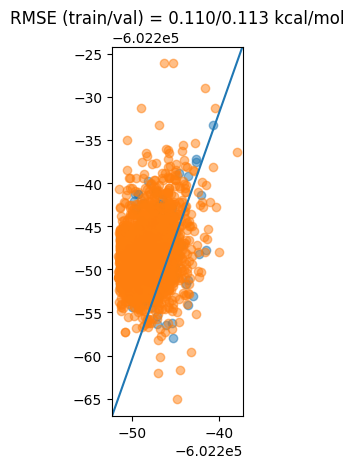

In [8]:
results_file, results = train_and_evaluate(CONFIG, ".", 
        )
plot_results(results)

batch_size: 128
l0: 0.1
learning_rate: 0.002
molecule: A2B2C
n_layers: 2
n_neurons: 128
ntr: 80
ntst: 100
num_epochs: 500
nval: 3420
poly_degree: 3
workdir: .

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
****
i0 30
(80, 1) (3420, 1)
80 4.8469215e-06 5.9208414e-06 0.29974782 2.2634199


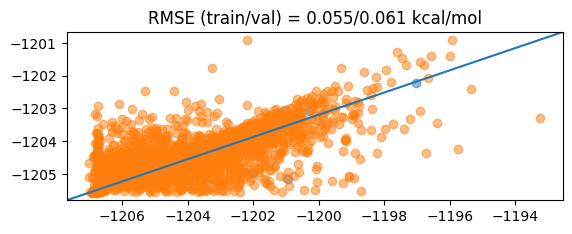

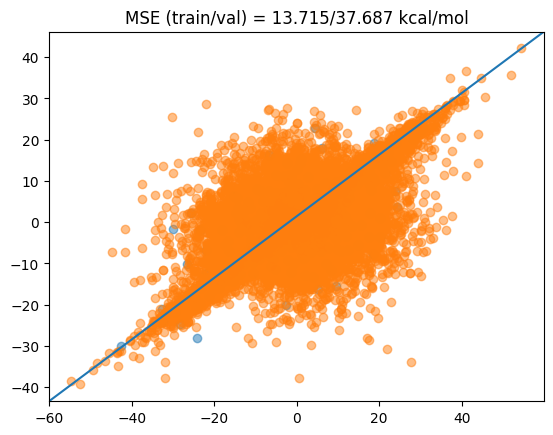

batch_size: 128
l0: 0.1
learning_rate: 0.002
molecule: A2B2C
n_layers: 2
n_neurons: 128
ntr: 80
ntst: 100
num_epochs: 500
nval: 3420
poly_degree: 3
workdir: .

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
****
i0 70
(80, 1) (3420, 1)
80 3.0421052e-06 6.465666e-06 0.3298992 2.2874143


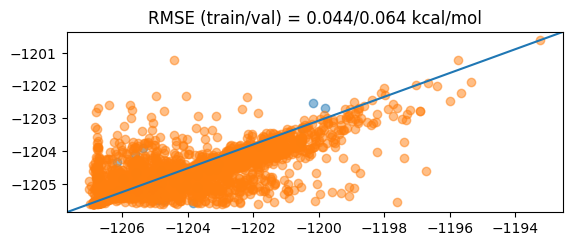

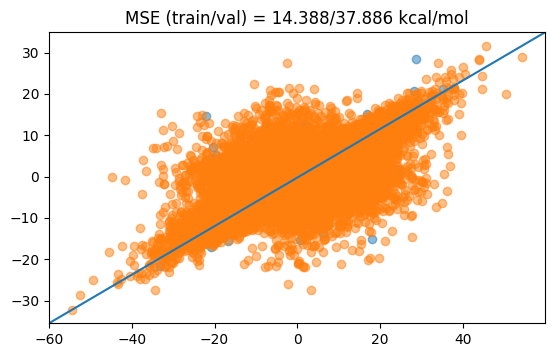

batch_size: 128
l0: 0.1
learning_rate: 0.002
molecule: A2B2C
n_layers: 2
n_neurons: 128
ntr: 80
ntst: 100
num_epochs: 500
nval: 3420
poly_degree: 3
workdir: .

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
****
i0 3
(80, 1) (3420, 1)
80 3.5146747e-06 5.1474776e-06 0.2846032 2.231897


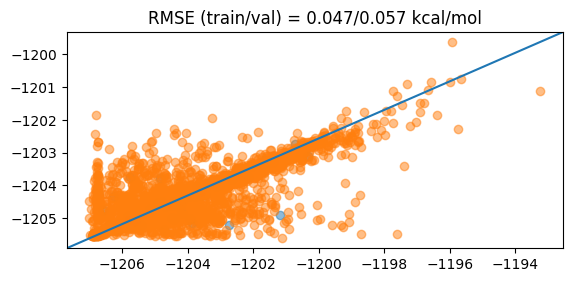

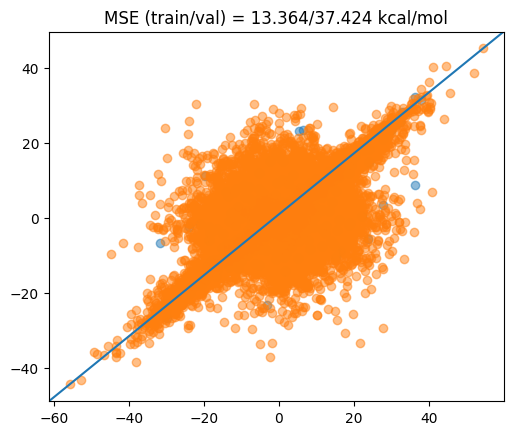

batch_size: 128
l0: 0.1
learning_rate: 0.002
molecule: A2B2C
n_layers: 2
n_neurons: 128
ntr: 80
ntst: 100
num_epochs: 500
nval: 3420
poly_degree: 3
workdir: .

/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
****
i0 11
(80, 1) (3420, 1)
80 4.0196205e-06 5.371995e-06 0.3213994 2.231633


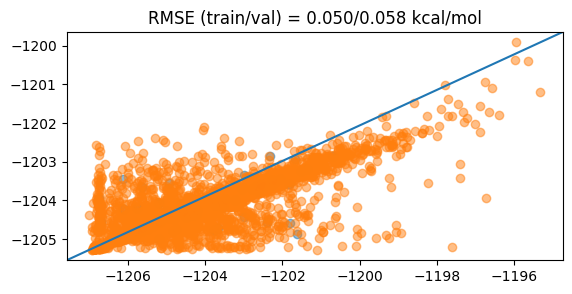

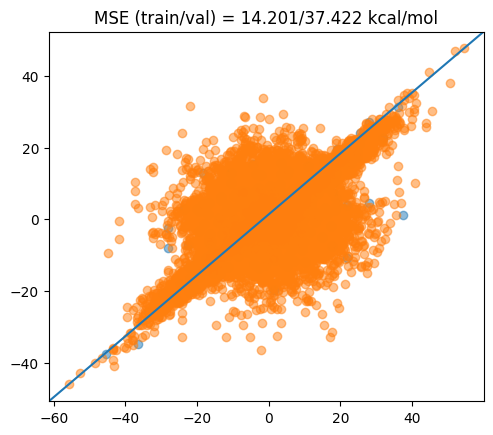

In [9]:
results_compilation = []
ntr_vals = [ 80 ]
all_ntr = []

i = 0
for j in range(4):
    for ntr in ntr_vals:
        CONFIG["ntr"] =  ntr
        CONFIG["nval"] = 3500 - ntr
    
        CONFIG["molecule"] = "A2B2C" #"ABCDE"
        results_file, results = train_and_evaluate_w_gradients(CONFIG, ".", 
                energy_normalization=True)
        plot_results(results)
        results_compilation.append(results)
        all_ntr.append(ntr)
        plt.show()

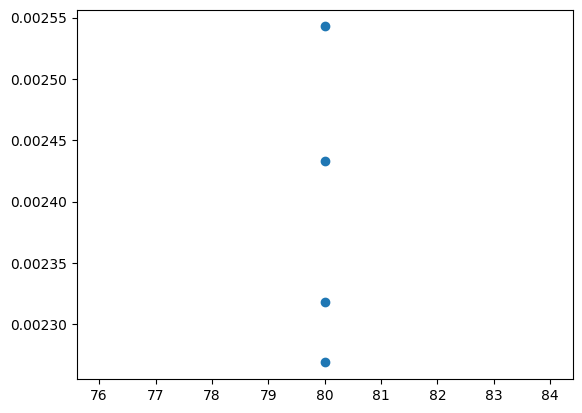

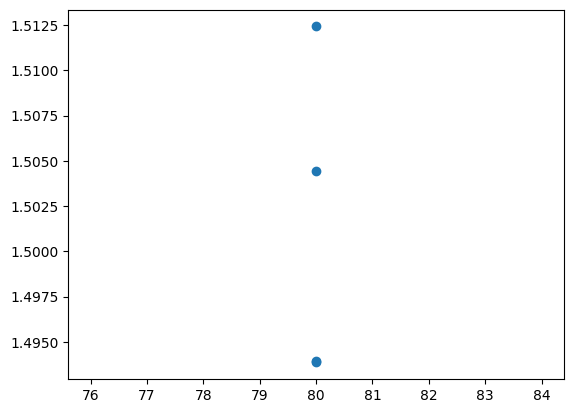

In [10]:
r_f = [_["loss_force_val"]**0.5 for _ in results_compilation]
r_e = [_["loss_val"]**0.5 for _ in results_compilation]

ntr = all_ntr
plt.scatter(ntr, r_e)

plt.show()
plt.scatter(ntr, r_f)

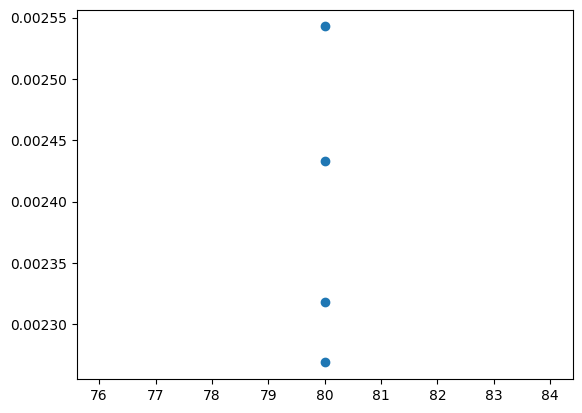

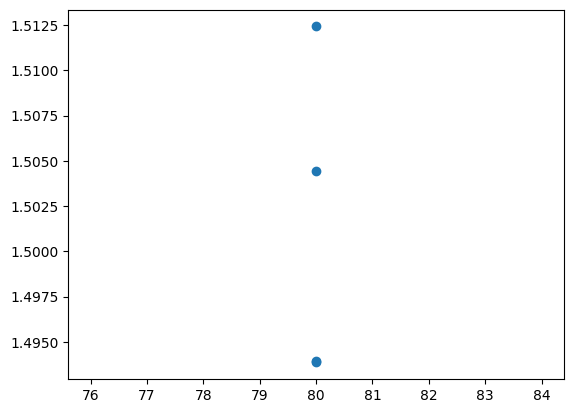

In [11]:
r_f = [_["loss_force_val"]**0.5 for _ in results_compilation]
r_e = [_["loss_val"]**0.5 for _ in results_compilation]

# ntr = [_ for _ in results_compilation.keys()]
plt.scatter(all_ntr, r_e)

plt.show()
plt.scatter(all_ntr, r_f)

In [12]:
results_compilation[0].keys()

dict_keys(['X_tr', 'F_tr', 'y_tr', 'y_pred_tr', 'F_pred_tr', 'X_val', 'y_val', 'y_pred_val', 'F_val', 'F_pred_val', 'loss_force_tr', 'loss_force_val', 'loss_tr', 'loss_val'])

In [13]:
def read_geometry_energy(filename: str = "/pchem-data/meuwly/boittier/home/pyscfgpu/tests/data/combined.xyz", 
                         num_atoms: int = 5,
                         energy_normalization: bool = False):

    print(os.getcwd())
    with open(filename, 'r') as file:
        data = file.read()

    # Split the data into blocks using a blank line as a separator
    blocks = re.split(r'\s\s5\n', data.strip())
    print("n blocks", len(blocks))
    # Initialize lists to store geometries and energies
    geometries = []
    energies = []
    atoms = []

    # Process each block

    for block in blocks:
        lines = block.split('\n')

        # Extract energy from the first line of each block
        if is_float(lines[0]) and not is_int(lines[0]):
            energy = float(lines[0])
        elif is_int(lines[0]):
            energy = float(lines[1])

        # Extract atom coordinates
        coordinates = []
        atoms_i = []
        for line in lines[1:]:
            parts = line.split()
            if len(parts) == 4 + 3:
                atom, x, y, z, dx, dy, dz = parts
                coordinates.append([float(x), float(y), float(
                    z), float(dx), float(dy), float(dz)])
                atoms_i.append((atom))

        # Append data to lists
        geometries.append(list(coordinates))
        energies.append(energy)
        atoms.append(list(atoms_i))
    
    energies = np.array(energies)
    geometries_and_forces = np.array(geometries) 
    geometries = geometries_and_forces[:, :, 0:3] # 1 / ang_to_bohr
    forces = geometries_and_forces[:, :, 3:] 
    if energy_normalization:
        Eref = np.zeros([20], dtype=float)
        Eref[1] = -0.498232909223
        Eref[6] = -37.731440432799
        Eref[8] = -74.878159582108
        Eref[17] = -459.549260062932
        energies -= np.array([-0.498232909223 * 2 + 2*-459.549260062932 + -37.731440432799]*len(energies))

    
    return jnp.array(geometries), jnp.array(forces), jnp.array(energies[:, np.newaxis]), np.array(atoms)


In [14]:
import os
import pandas as pd

import jax
import jax.numpy as jnp

from molpipx import PIPNN
from molpipx import mse_loss
from molpipx import get_functions, detect_molecule, split_train_and_test_data_w_forces
from molpipx import get_energy_and_forces

from jaxtyping import (
    Array,
    Float,
    PyTree,
    install_import_hook,
)

from flax.training import train_state, checkpoints
import chex
import optax
from optax import ema

from ml_collections import config_dict

from absl import logging
import pandas as pd

import jax
import jax.numpy as jnp

from molpipx import PIPNN
from molpipx import mse_loss
from molpipx import get_functions, detect_molecule, split_train_and_test_data_w_forces

from jaxtyping import (
    Array,
    Float,
    PyTree,
    install_import_hook,
)

import flax
from flax.training import train_state, checkpoints
import chex
import optax
from optax import ema

from ml_collections import config_dict





@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)


def train_epoch(state, train_ds, batch_size, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['x'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, len(train_ds['x']))
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_x = train_ds['x'][perm, ...]
        batch_y = train_ds['e'][perm, ...]
        grads, loss = apply_model_training(state, batch_x, batch_y)
        state = update_model(state, grads)
        epoch_loss.append(loss)
    train_loss = jnp.mean(jnp.array(epoch_loss))
    return state, train_loss



def get_number_of_atoms(molecule_dict):
    na = 0
    for i, k in enumerate(molecule_dict):
        na += molecule_dict[k]
    return na


def create_train_state(rng, config):
    """Creates initial `TrainState`."""
    molecule_type = config.molecule
    poly_degree = config.poly_degree
    n_layers = config.n_layers
    n_neurons = config.n_neurons
    features = ()
    for i in range(n_layers):
        features = features + (n_neurons,)

    mol_dict, mol_sym = detect_molecule(molecule_type)
    na = get_number_of_atoms(mol_dict)
    f_mono, f_poly = get_functions(molecule_type, poly_degree)

    pipnn = PIPNN(f_mono, f_poly, features,)
    params = pipnn.init(rng, jnp.ones([1, na, 3]))['params']
    tx = optax.adam(config.learning_rate)
    return train_state.TrainState.create(apply_fn=pipnn.apply, params=params, tx=tx)


@chex.dataclass
class loss_values:
    tr_loss: chex.ArrayDevice
    val_loss: chex.ArrayDevice




@jax.jit
def apply_model_training(state, geometries, force_true, e_true, l0):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        e_pred, f_pred = state.apply_fn({'params': params}, geometries)
        e_pred = jnp.expand_dims(e_pred, axis=1)
        loss_e = mse_loss(e_pred, e_true)
        loss_f = jnp.linalg.norm(f_pred - force_true)

        return l0*loss_e + loss_f, (loss_e, loss_f)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (loss_e, loss_f)), grads = grad_fn(state.params)
    return grads, (loss, (loss_e, loss_f))


@jax.jit
def apply_model(state, geometries, force_true, e_true):
    """Computes gradients, loss and accuracy for a single batch."""
    e_pred, f_pred = state.apply_fn({'params': state.params}, geometries)
    loss_e = mse_loss(e_pred, e_true)
    loss_f = jnp.linalg.norm(f_pred - force_true)
    return loss_e, loss_f


@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)


def train_epoch(state, train_ds, batch_size, rng, l0):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['x'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, len(train_ds['x']))
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []
    epoch_e_loss = []
    epoch_f_loss = []

    for perm in perms:
        batch_x = train_ds['x'][perm, ...]
        batch_f = train_ds['f'][perm, ...]
        batch_y = train_ds['e'][perm, ...]
        grads, (loss, (loss_e, loss_f)) = apply_model_training(
            state, batch_x, batch_f, batch_y, l0)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_e_loss.append(loss_e)
        epoch_f_loss.append(loss_f)
    train_loss = jnp.mean(jnp.array(epoch_loss))
    train_e_loss = jnp.mean(jnp.array(epoch_e_loss))
    train_f_loss = jnp.mean(jnp.array(epoch_f_loss))
    return state, (train_loss, train_e_loss, train_f_loss)


def get_datasets(n_tr, key, n_val=1000):

    X_all, F_all, y_all, atoms_all = read_geometry_energy(energy_normalization=True)
    (X_tr, F_tr, y_tr), (X_val, F_val, y_val) = split_train_and_test_data_w_forces(
        X_all, F_all, y_all, n_tr, key, n_val)

    train_ds = {'x': X_tr, 'f': F_tr, 'e': y_tr}
    val_ds = {'x': X_val, 'f': F_val, 'e': y_val}

    return train_ds, val_ds


def get_number_of_atoms(molecule_dict):
    na = 0
    for i, k in enumerate(molecule_dict):
        na += molecule_dict[k]
    return na


def create_train_state(rng, config):
    """Creates initial `TrainState`."""
    molecule_type = config.molecule
    poly_degree = config.poly_degree
    n_layers = config.n_layers
    n_neurons = config.n_neurons
    features = ()
    for i in range(n_layers):
        features = features + (n_neurons,)

    mol_dict, mol_sym = detect_molecule(molecule_type)
    na = get_number_of_atoms(mol_dict)
    f_mono, f_poly = get_functions(molecule_type, poly_degree)

    pipnn = PIPNN(f_mono, f_poly, features,)
    params = pipnn.init(rng, jnp.ones([1, na, 3]))['params']
    tx = optax.adam(config.learning_rate)

    @jax.jit
    def f_w_grad(params, geoms): return get_energy_and_forces(
        pipnn.apply, geoms, params)

    return train_state.TrainState.create(apply_fn=f_w_grad, 
                                         params=params, 
                                         tx=tx), pipnn


@chex.dataclass
class loss_values:
    tr_loss: chex.ArrayDevice
    tr_e_loss: chex.ArrayDevice
    tr_f_loss: chex.ArrayDevice


def train_and_evaluate(
    config: config_dict.ConfigDict,
    workdir: str
) -> train_state.TrainState:
    """Execute model training and evaluation loop.

    Args:
      config: Hyperparameter configuration for training and evaluation.
      workdir: Directory where the tensorboard summaries are written to.

    Returns:
      The train state (which includes the `.params`).
    """
    rng = jax.random.key(0)

    n_tr = config.ntr
    n_val = config.nval
    n_tst = config.ntst
    l0 = config.l0

    workdir_parms = workdir + f'_l0_{l0:.4f}'
    if not os.path.exists(workdir_parms):
        os.makedirs(workdir_parms)

        # read training data
    train_ds, val_ds = get_datasets(n_tr, rng, n_val)

    rng, init_rng = jax.random.split(rng)
    state, _pipnn_ = create_train_state(init_rng, config)

    loss_trj_ema = ema(decay=0.99)
    loss_trj_ema_state = loss_trj_ema.init(loss_values(tr_loss=jnp.array(0.),
                                                       tr_e_loss=jnp.array(0.),
                                                       tr_f_loss=jnp.array(0.)))

    df = pd.DataFrame()
    rng, init_rng = jax.random.split(init_rng)
    for epoch in range(1, config.num_epochs + 1):
        rng, input_rng = jax.random.split(rng)

        state, (train_loss, train_e_loss, train_f_loss) = train_epoch(
            state, train_ds, config.batch_size, input_rng, l0
        )
        val_e_loss, val_f_loss = apply_model(
            state, val_ds['x'], val_ds['f'], val_ds['e'])

        epoch_values = loss_values(
            tr_loss=train_loss,
            tr_e_loss=train_e_loss,
            tr_f_loss=train_f_loss,)
        # values ema
        epoch_values_ema, loss_trj_ema_state = loss_trj_ema.update(
            epoch_values, loss_trj_ema_state)

        print('epoch:% 3d, (ema)tr_loss: %.4f, (ema)train_e_loss: %.6f, (ema)tr_f_loss: %.4f, val_e_loss: %.6f, val_f_loss: %.6f'
              % (
                  epoch,
                  epoch_values_ema.tr_loss,
                  epoch_values_ema.tr_e_loss,
                  epoch_values_ema.tr_f_loss,
                  val_e_loss, val_f_loss,
              ))
        r_epoch = {'epoch': epoch,
                   'tr_loss': train_loss,
                   'ema_tr_loss': epoch_values_ema.tr_loss,
                   'ema_tr_e_loss': epoch_values_ema.tr_e_loss,
                   'ema_tr_f_loss': epoch_values_ema.tr_f_loss,
                   'val_e_loss': val_e_loss,
                   'val_f_loss': val_f_loss,
                   }
        df = pd.concat(
            [df, pd.DataFrame(r_epoch, index=[0])], ignore_index=True)
        df.to_csv(
            f"{workdir}/training_trajectory_ema_wgrad_l0_{l0:.4f}.csv", index=False)

        # save models
        checkpoints.save_checkpoint(
            ckpt_dir=workdir_parms, target=state.params, step=epoch, keep=1, overwrite=True)

    return state, df, _pipnn_, state.params

2025-02-26 23:33:57.935824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740609237.956914  652976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740609237.963557  652976 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
from pathlib import Path

def get_default_config():
    """Get the default hyperparameter configuration."""
    config = config_dict.ConfigDict()

    config.molecule = "A2B2C"#'ABCDE'
    config.poly_degree = 5

    config.learning_rate = 1E-3
    config.batch_size = 24
    config.num_epochs = 50
    config.n_layers = 2
    config.n_neurons = 128
    config.ntr = 2000
    config.nval = 2500
    config.ntst = 300
    config.l0 = 10
    return config


def main():
    workdir= str(Path(".").absolute())
    # config, workdir, bool_grad = merge_configs()
    print("Effective Configuration:")
    CONFIG = get_default_config()
    print(CONFIG)
    print(workdir)
    bool_grad = True
    if bool_grad:
        return train_and_evaluate(CONFIG, workdir)



In [16]:
from molpipx import get_energy_and_forces

RAND = jax.random.PRNGKey(0)
# test.keys()
config = get_default_config()

In [17]:
datasets = get_datasets(config.ntr, RAND, n_val=config.nval)
train, test = datasets


/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574


In [18]:
from lovely_jax import monkey_patch
monkey_patch()


In [19]:
"""Creates initial `TrainState`."""

config = get_default_config()

rng = jax.random.PRNGKey(0)

molecule_type = config.molecule
poly_degree = config.poly_degree
n_layers = config.n_layers
n_neurons = config.n_neurons
features = ()
for i in range(n_layers):
    features = features + (n_neurons,)

mol_dict, mol_sym = detect_molecule(molecule_type)
na = get_number_of_atoms(mol_dict)
f_mono, f_poly = get_functions(molecule_type, poly_degree)

pipnn = PIPNN(f_mono, f_poly, features, l=1.5)
params = pipnn.init(rng, jnp.ones([1, na, 3]))['params']
tx = optax.adam(config.learning_rate)

pipnn


JitPIPNN(
    # attributes
    f_mono = f_monomials
    f_poly = f_polynomials
    features = (128, 128)
    l = 1.5
    act_fun = tanh
)

In [20]:
rng = jax.random.key(0)
workdir= str(Path(".").absolute())

n_tr = config.ntr
n_val = config.nval
n_tst = config.ntst
l0 = config.l0

workdir_parms = workdir + f'_l0_{l0:.4f}'
if not os.path.exists(workdir_parms):
    os.makedirs(workdir_parms)

    # read training data
train_ds, val_ds = get_datasets(n_tr, rng, n_val)

rng, init_rng = jax.random.split(rng)
state, _pipnn_ = create_train_state(init_rng, config)

loss_trj_ema = ema(decay=0.99)
loss_trj_ema_state = loss_trj_ema.init(loss_values(tr_loss=jnp.array(0.),
                                                   tr_e_loss=jnp.array(0.),
                                                   tr_f_loss=jnp.array(0.)))

df = pd.DataFrame()
rng, init_rng = jax.random.split(init_rng)
for epoch in range(1, config.num_epochs + 1):
    rng, input_rng = jax.random.split(rng)

    state, (train_loss, train_e_loss, train_f_loss) = train_epoch(
        state, train_ds, config.batch_size, input_rng, l0
    )
    val_e_loss, val_f_loss = apply_model(
        state, val_ds['x'], val_ds['f'], val_ds['e'])

    epoch_values = loss_values(
        tr_loss=train_loss,
        tr_e_loss=train_e_loss,
        tr_f_loss=train_f_loss,)
    # values ema
    epoch_values_ema, loss_trj_ema_state = loss_trj_ema.update(
        epoch_values, loss_trj_ema_state)

    print('epoch:% 3d, (ema)tr_loss: %.4f, (ema)train_e_loss: %.6f, (ema)tr_f_loss: %.4f, val_e_loss: %.6f, val_f_loss: %.6f'
          % (
              epoch,
              epoch_values_ema.tr_loss,
              epoch_values_ema.tr_e_loss,
              epoch_values_ema.tr_f_loss,
              val_e_loss, val_f_loss,
          ))
    r_epoch = {'epoch': epoch,
               'tr_loss': train_loss,
               'ema_tr_loss': epoch_values_ema.tr_loss,
               'ema_tr_e_loss': epoch_values_ema.tr_e_loss,
               'ema_tr_f_loss': epoch_values_ema.tr_f_loss,
               'val_e_loss': val_e_loss,
               'val_f_loss': val_f_loss,
               }
    df = pd.concat(
        [df, pd.DataFrame(r_epoch, index=[0])], ignore_index=True)
    df.to_csv(
        f"{workdir}/training_trajectory_ema_wgrad_l0_{l0:.4f}.csv", index=False)

    # save models
    checkpoints.save_checkpoint(
        ckpt_dir=workdir_parms, target=state.params, step=epoch, keep=1, overwrite=True)


/pchem-data/meuwly/boittier/home/project-mmml/pips
n blocks 4574
epoch:  1, (ema)tr_loss: 3.6839, (ema)train_e_loss: 0.217411, (ema)tr_f_loss: 1.5098, val_e_loss: 0.000259, val_f_loss: 2.440950
epoch:  2, (ema)tr_loss: 1.9473, (ema)train_e_loss: 0.108191, (ema)tr_f_loss: 0.8654, val_e_loss: 0.000013, val_f_loss: 2.287366
epoch:  3, (ema)tr_loss: 1.3655, (ema)train_e_loss: 0.071778, (ema)tr_f_loss: 0.6477, val_e_loss: 0.000141, val_f_loss: 2.317654
epoch:  4, (ema)tr_loss: 1.0719, (ema)train_e_loss: 0.053571, (ema)tr_f_loss: 0.5362, val_e_loss: 0.000010, val_f_loss: 2.153447
epoch:  5, (ema)tr_loss: 0.8948, (ema)train_e_loss: 0.042651, (ema)tr_f_loss: 0.4683, val_e_loss: 0.000057, val_f_loss: 2.040781
epoch:  6, (ema)tr_loss: 0.7754, (ema)train_e_loss: 0.035369, (ema)tr_f_loss: 0.4217, val_e_loss: 0.000010, val_f_loss: 1.991177
epoch:  7, (ema)tr_loss: 0.6898, (ema)train_e_loss: 0.030169, (ema)tr_f_loss: 0.3881, val_e_loss: 0.000015, val_f_loss: 1.976618
epoch:  8, (ema)tr_loss: 0.6250,

In [21]:
X = test["x"]
X

Array[2500, 5, 3] n=37500 (0.1Mb) x∈[-22.692, 21.918] μ=-0.067 σ=9.643 gpu:1

In [22]:
variables = pipnn.init(jax.random.PRNGKey(0), X)

In [23]:
train

{'x': Array[2000, 5, 3] n=30000 (0.1Mb) x∈[-22.467, 21.901] μ=-0.051 σ=9.586 gpu:1,
 'f': Array[2000, 5, 3] n=30000 (0.1Mb) x∈[-0.089, 0.087] μ=1.006e-08 σ=0.013 gpu:1,
 'e': Array[2000, 1] 7.8Kb x∈[-1.923, -1.905] μ=-1.919 σ=0.003 gpu:1}

In [24]:
test

{'x': Array[2500, 5, 3] n=37500 (0.1Mb) x∈[-22.692, 21.918] μ=-0.067 σ=9.643 gpu:1,
 'f': Array[2500, 5, 3] n=37500 (0.1Mb) x∈[-0.073, 0.081] μ=4.314e-09 σ=0.013 gpu:1,
 'e': Array[2500, 1] 9.8Kb x∈[-1.923, -1.902] μ=-1.919 σ=0.003 gpu:1}

In [25]:
params = {"params": state.params}
params

{'params': {'last_layer': {'bias': Array[1] gpu:1 [-0.028],
   'kernel': Array[128, 1] x∈[-0.199, 0.174] μ=-0.008 σ=0.086 gpu:1},
  'layers_0': {'bias': Array[128] x∈[-0.045, 0.046] μ=-0.001 σ=0.028 gpu:1,
   'kernel': Array[904, 128] n=115712 (0.4Mb) x∈[-0.329, 0.307] μ=0.000 σ=0.045 gpu:1},
  'layers_1': {'bias': Array[128] x∈[-0.032, 0.036] μ=0.004 σ=0.028 gpu:1,
   'kernel': Array[128, 128] n=16384 (64Kb) x∈[-0.218, 0.227] μ=-0.000 σ=0.089 gpu:1}}}

In [26]:
# for k in state.params.keys():
#     variables["params"][k] = state.params[k]
y_pred = pipnn.apply(params, test["x"])
y_pred_train= pipnn.apply(params, train["x"])
test["e"], y_pred, train["e"], y_pred_train

(Array[2500, 1] 9.8Kb x∈[-1.923, -1.902] μ=-1.919 σ=0.003 gpu:1,
 Array[2500, 1] 9.8Kb x∈[-1.923, -1.915] μ=-1.921 σ=0.001 gpu:1,
 Array[2000, 1] 7.8Kb x∈[-1.923, -1.905] μ=-1.919 σ=0.003 gpu:1,
 Array[2000, 1] 7.8Kb x∈[-1.922, -1.914] μ=-1.920 σ=0.001 gpu:1)

(array([622., 735., 543., 351., 161.,  55.,  22.,   7.,   2.,   2.]),
 array([-1.66499615e-03, -8.65626324e-04, -6.62565217e-05,  7.33113266e-04,
         1.53248315e-03,  2.33185291e-03,  3.13122268e-03,  3.93059244e-03,
         4.72996244e-03,  5.52933197e-03,  6.32870197e-03]),
 <BarContainer object of 10 artists>)

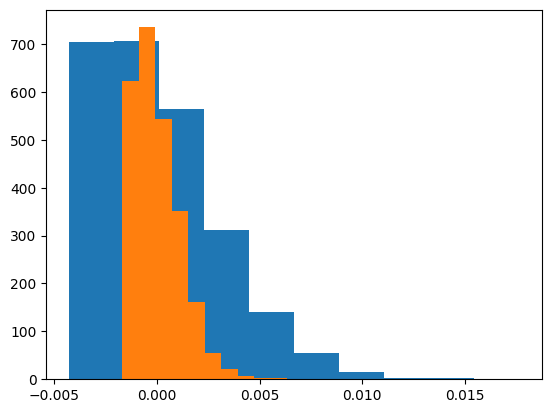

In [27]:
plt.hist(test["e"] - test["e"].mean())
plt.hist(y_pred - y_pred.mean())

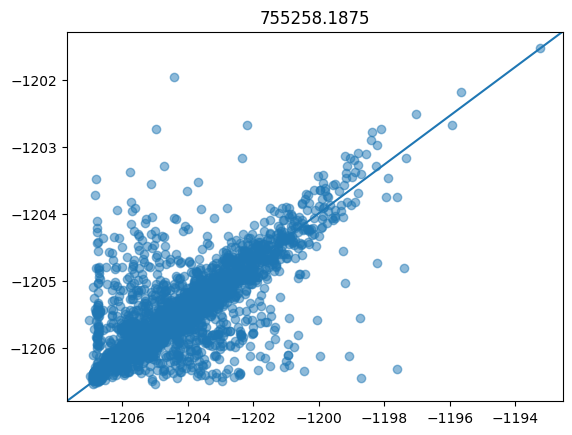

In [28]:
plt.title(float(627.509 * mse_loss(test["e"], 627.509 * y_pred)**0.5))

plt.scatter(627.509 *test["e"], 627.509 *y_pred, alpha=0.5)
# plt.gca().set_aspect("equal")
ax = plt.gca()
plt.plot([0,1], [0,1], transform=ax.transAxes)

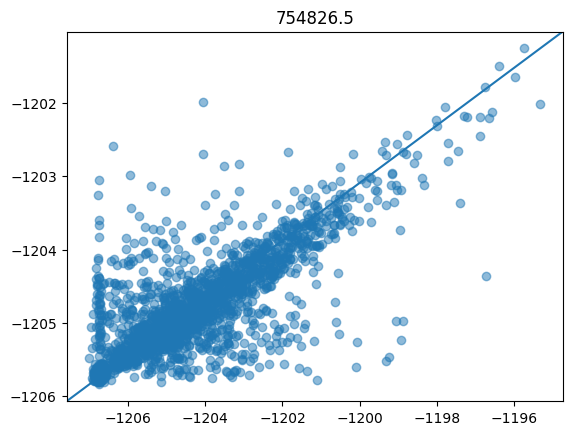

Traceback (most recent call last):
  File "/pchem-data/meuwly/boittier/home/miniforge3/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pchem-data/meuwly/boittier/home/miniforge3/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/pchem-data/meuwly/boittier/home/pycharmm_test/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

In [29]:
plt.title(float(627.509 * mse_loss(train["e"], 627.509 * y_pred_train)**0.5))
plt.scatter(627.509 *train["e"], 627.509 *y_pred_train, alpha=0.5)
# plt.gca().set_aspect("equal")
ax = plt.gca()
plt.plot([0,1], [0,1], transform=ax.transAxes)